# Setting up

## load modules

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
import os
import gc
import psutil
import numpy as np
import xarray as xr
import holoviews as hv
import matplotlib.pyplot as plt
import bokeh.plotting as bpl
import dask.array as da
import pandas as pd
import dask
import datashader as ds
import itertools as itt
import papermill as pm
import ast
import functools as fct
from holoviews.operation.datashader import datashade, regrid, dynspread
from datashader.colors import Sets1to3
from dask.diagnostics import ProgressBar
from IPython.core.display import display, HTML
from dask.distributed import Client, progress, LocalCluster, fire_and_forget

## set path and parameters

In [2]:
#Set up Initial Basic Parameters#
minian_path = "."
dpath = "./demo_movies/"
chunks = {"frame": 1000, "height": 50, "width": 50, "unit_id": 100}
in_memory = True
interactive = True
output_size = 60
param_save_minian = {
    'dpath': dpath,
    'fname': 'minian',
    'backend': 'zarr',
    'meta_dict': dict(seesion_id=-1, session=-2, animal=-3),
    'overwrite': True}

#Pre-processing Parameters#
param_load_videos = {
    'pattern': 'msCam[0-9]+\.avi$',
    'dtype': np.float32,
    'in_memory': in_memory,
    'downsample': dict(frame=2),
    'downsample_strategy': 'subset'}
subset = {
    'frame': slice(0, None),
    'height': slice(0, None),
    'width': slice(0, None)}
param_glow_removal = {
    'method': 'uniform',
    'wnd': 51}
param_brightspot_removal = {
    'thres': 2}
param_first_denoise = {
    'method': 'median',
    'ksize': 5}
param_second_denoise = {
    'method': 'gaussian',
    'sigmaX': 0,
    'ksize': (5, 5)}

#Motion Correction Parameters#
subset_mc = None
param_estimate_shift = {
    'dim': 'frame',
    'on': 'first',
    'pad_f': 1,
    'pct_thres': 99.99}

#Background Removal Parameters#
param_background_removal = {
    'method': 'tophat',
    'wnd': 10}

#Initialization Parameters#
param_seeds_init = {
    'wnd_size': 2000,
    'method': 'rolling',
    'stp_size': 1000,
    'nchunk': 100,
    'max_wnd': 10}
param_gmm_refine = {
    'q': (0.1, 99.9),
    'n_components': 2,
    'valid_components': 1,
    'mean_mask': True}
param_pnr_refine = {
    'noise_freq': 0.06,
    'thres': 'auto',
    'med_wnd': None}
param_ks_refine = {
    'sig': 0.05}
param_seeds_merge = {
    'thres_dist': 5,
    'thres_corr': 0.7,
    'noise_freq': 'envelope'}
param_initialize = {
    'thres_corr': 0.8,
    'wnd': 10}

#CNMF Parameters#
param_get_noise = {
    'noise_range': (0.06, 0.5),
    'noise_method': 'logmexp'}
param_first_spatial = {
    'dl_wnd': 5,
    'sparse_penal': 0.1,
    'update_background': False,
    'post_scal': True,
    'zero_thres': 'eps'}
param_first_temporal = {
    'noise_freq': 0.06,
    'sparse_penal': 1,
    'p': 2,
    'add_lag': 20,
    'use_spatial': False,
    'chk': chunks,
    'jac_thres': 0.1,
    'zero_thres': 1e-8,
    'max_iters': 200,
    'use_smooth': True,
    'scs_fallback': False,
    'post_scal': True}
param_first_merge = {
    'thres_corr': 0.9}
param_second_spatial = {
    'dl_wnd': 5,
    'sparse_penal': 0.05,
    'update_background': False,
    'post_scal': True,
    'zero_thres': 'eps'}
param_second_temporal = {
    'noise_freq': 0.06,
    'sparse_penal': 1,
    'p': 2,
    'add_lag': 20,
    'use_spatial': False,
    'chk': chunks,
    'jac_thres': 0.1,
    'zero_thres': 1e-8,
    'max_iters': 500,
    'use_smooth': True,
    'scs_fallback': False,
    'post_scal': True}
param_second_merge = {
    'thres_corr': 0.9}

## import minian

In [3]:
%%capture
sys.path.append(minian_path)
from minian.utilities import load_params, load_videos, scale_varr, scale_varr_da, save_variable, open_minian, save_minian, handle_crash
from minian.preprocessing import remove_brightspot, gradient_norm, denoise, remove_background, stripe_correction
from minian.motion_correction import estimate_shift_fft, apply_shifts, interpolate_frame, mask_shifts
from minian.initialization import seeds_init, gmm_refine, pnr_refine, intensity_refine, ks_refine, seeds_merge, initialize
from minian.cnmf import psd_welch, psd_fft, get_noise, update_spatial, update_temporal, unit_merge, smooth_sig
from minian.visualization import VArrayViewer, CNMFViewer, generate_videos, visualize_seeds, visualize_gmm_fit, visualize_spatial_update, visualize_temporal_update, roi_draw

## module initialization

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
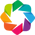

In [4]:
dpath = os.path.abspath(dpath)
para_norm_list = ['meta_dict', 'chunks', 'subset', 'subset_mc']
for par_key in list(globals().keys()):
    if par_key in para_norm_list or par_key.startswith('param_'):
        globals()[par_key] = load_params(globals()[par_key])
if interactive:
    hv.notebook_extension('bokeh', width=100)
    pbar = ProgressBar()
    pbar.register()
else:
    hv.notebook_extension('matplotlib')

# Pre-processing

## loading videos and visualization

In [5]:
%%time
handle_crash = fct.partial(
    handle_crash,
    frame_dict={
        '181216_exposure': 10 * 60 * 30,
        '181218_training': 242 * 30,
        '181220_test1': 5 * 60 * 30,
        '181222_test2': 5 * 60 * 30,
        '181224_test3': 5 * 60 * 30})
varr = load_videos(dpath, post_process=handle_crash, **param_load_videos)

loading 1 videos in folder /home/susiefeng/fork_clone/minian/demo_movies
[########################################] | 100% Completed |  0.1s
CPU times: user 398 ms, sys: 21 ms, total: 419 ms
Wall time: 344 ms


In [6]:
if in_memory:
    varr = varr.persist()

[########################################] | 100% Completed | 27.7s


In [7]:
hv.output(size=output_size)
if interactive:
    vaviewer = VArrayViewer(varr, framerate=5)
    display(vaviewer.show())

computing summary
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  0.1s


Column
    [0] WidgetBox
        [0] Button(button_type='primary', name='Update Mask')
        [1] Player(end=499, interval=10, width=500)
    [1] Row
        [0] HoloViews(Layout)

## subset part of video

In [8]:
varr_ref = varr.sel(subset)
if subset:
    for sub_key in subset.keys():
        varr_reg = varr_ref.dropna(sub_key)
varr_ref = varr_ref.where(varr_ref.sum(['height', 'width']) > 0).dropna('frame')
varr_ref = varr_ref.chunk(dict(frame=int(chunks['frame']/10), height=-1, width=-1))

[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.2s


## stripe correction

In [9]:
%%time
#varr_ref = stripe_correction(varr_ref, reduce_dim='width')
#if in_memory:
#    with ProgressBar():
#        varr_ref = varr_ref.persist()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


## glow removal

In [10]:
varr_ref = remove_background(varr_ref, **param_glow_removal)
if in_memory:
    varr_ref = varr_ref.persist()

[########################################] | 100% Completed |  1.2s


## bright spots removal

In [11]:
%%time
varr_ref = remove_brightspot(varr_ref, **param_brightspot_removal)
if in_memory:
    varr_ref = varr_ref.persist()

[########################################] | 100% Completed |  1.1s
CPU times: user 2.3 s, sys: 218 ms, total: 2.52 s
Wall time: 1.15 s


## denoise

In [12]:
%%time
varr_ref = denoise(varr_ref, **param_first_denoise)
if in_memory:
    varr_ref = varr_ref.persist()

[########################################] | 100% Completed |  0.1s
CPU times: user 285 ms, sys: 64 ms, total: 349 ms
Wall time: 107 ms


In [13]:
%%time
varr_ref = denoise(varr_ref, **param_second_denoise)
if in_memory:
    varr_ref = varr_ref.persist()

[########################################] | 100% Completed |  0.1s
CPU times: user 99.7 ms, sys: 80.5 ms, total: 180 ms
Wall time: 107 ms


# motion correction

## select motion correction roi

In [40]:
hv.output(size=output_size)
if interactive:
    vaviewer = VArrayViewer(varr, framerate=5)
    display(vaviewer.show())
    #str_box = roi_draw(varr_ref.isel(frame=0))

computing summary
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  0.1s


Column
    [0] WidgetBox
        [0] Button(button_type='primary', name='Update Mask')
        [1] Player(end=499, interval=10, width=500)
    [1] Row
        [0] HoloViews(Layout)

In [36]:
if interactive:
    im, str_box = roi_draw(varr_ref.isel(frame=0))
    display(im)

[########################################] | 100% Completed |  0.1s


:DynamicMap   []
   :Overlay
      .Image.I    :Image   [width,height]   (demo_movies_subtracted_clean_denoised_denoised)
      .Polygons.I :Polygons   [x,y]

In [41]:
subset_mc

In [43]:
if interactive:
    try:
        subset_mc = {
            'height': slice(str_box.data['y0'][0], str_box.data['y1'][0]),
            'width': slice(str_box.data['x0'][0], str_box.data['x1'][0])}
    except IndexError:
        subset_mc = None

## estimate shifts

In [ ]:
%%time
res = estimate_shift_fft(varr_ref.sel(subset_mc), **param_estimate_shift)
if in_memory:
    res = res.compute()
shifts = res.sel(variable = ['height', 'width'])
corr = res.sel(variable='corr')

## masking and interpolation

In [ ]:
%%time
# shifts, mask = mask_shifts(varr_ref, corr, shifts, z_thres=-1.5)

In [ ]:
%%time
# varr_ref = interpolate_frame(varr_ref.compute().rename('varr_mc'), mask)

## determine shifts

### take cumulative sum if `on='perframe'` when estimating shifts

In [ ]:
# shifts = shifts.cumsum('frame')

## visualization of shifts

In [ ]:
%%opts Curve [width=500, tools=['hover']]
hv.output(size=output_size)
if interactive and in_memory:
    display(hv.NdOverlay(dict(width=hv.Curve(shifts.sel(variable='width')),
                      height=hv.Curve(shifts.sel(variable='height')))))

## apply shifts

In [ ]:
varr_mc = apply_shifts(varr_ref, shifts)
varr_mc = varr_mc.ffill('height').bfill('height').ffill('width').bfill('width')
if in_memory:
    varr_mc = varr_mc.persist()

## visualization of motion-correction

In [ ]:
hv.output(size=output_size)
if interactive and in_memory:
    vaviewer = VArrayViewer(varr_mc.rename('varr_mc'), framerate=5)
    display(vaviewer.show())

## save result

In [ ]:
%%time
save_minian(shifts.rename('shifts'), **param_save_minian)
save_minian(varr_mc.rename('org'), **param_save_minian)

# background removal

## load in from disk

In [ ]:
varr_mc = open_minian(dpath,
                      fname=param_save_minian['fname'],
                      backend=param_save_minian['backend'])['org']

## background removal

In [ ]:
%%time
Y = remove_background(varr_mc, **param_background_removal)
if in_memory:
    with dask.config.set(scheduler='processes'):
        Y = Y.persist()

## normalization

In [ ]:
%%time
Y = scale_varr(Y)
if in_memory:
    Y = Y.persist()

## visualization of background removal

In [ ]:
hv.output(size=output_size)
if interactive and in_memory:
    vaviewer = VArrayViewer(Y.rename('Y'), framerate=5)
    display(vaviewer.show())

## save result

In [ ]:
%%time
with dask.config.set(scheduler='processes'):
    save_minian(Y.rename('Y'), **param_save_minian)

# initialization

In [ ]:
%%time
minian = open_minian(dpath,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'])

In [ ]:
Y = minian['Y']
max_proj = Y.max('frame').compute()
Y_flt = Y.stack(spatial=['height', 'width'])

## generating over-complete set of seeds

In [ ]:
%%time
seeds = seeds_init(Y, **param_seeds_init)

In [ ]:
visualize_seeds(max_proj, seeds)

## gaussian-mixture-model refine

In [ ]:
%%time
seeds_gmm, pv, gmm= gmm_refine(Y_flt, seeds, **param_gmm_refine)

In [ ]:
visualize_gmm_fit(pv, gmm, 100)

In [ ]:
visualize_seeds(max_proj, seeds_gmm, 'mask_gmm')

## peak-noise-ratio refine

In [ ]:
%%time
if interactive:
    noise_freq_list = [0.005, 0.01, 0.02, 0.06, 0.1, 0.2, 0.3, 0.45]
    example_seeds = seeds_gmm[seeds_gmm['mask_gmm']].sample(6, axis='rows')
    example_trace = (Y_flt
                     .sel(spatial=[tuple(hw) for hw in example_seeds[['height', 'width']].values])
                     .assign_coords(spatial=np.arange(6)))
    smooth_dict = dict()
    for freq in noise_freq_list:
        trace_smth_low = smooth_sig(example_trace, freq)
        trace_smth_high = smooth_sig(example_trace, freq, btype='high')
        trace_smth_low = trace_smth_low.compute()
        trace_smth_high = trace_smth_high.compute()
        hv_trace = hv.HoloMap({
            'signal': hv.Dataset(trace_smth_low).to(hv.Curve, kdims=['frame']),
            'noise': hv.Dataset(trace_smth_high).to(hv.Curve, kdims=['frame'])
        }, kdims='trace').collate()
        smooth_dict[freq] = hv_trace

In [ ]:
hv.output(size=output_size)
if interactive:
    hv_res = (hv.HoloMap(smooth_dict, kdims=['noise_freq']).collate().opts(plot=dict(height=400, width=600))
              .overlay('trace').layout('spatial').cols(3))
    display(hv_res)

In [ ]:
seeds_pnr, pnr, gmm = pnr_refine(Y_flt, seeds_gmm[seeds_gmm['mask_gmm']].copy(), **param_pnr_refine)

In [ ]:
hv.Histogram(np.histogram(pnr.values, bins=50))

In [ ]:
if gmm:
    display(visualize_gmm_fit(pnr, gmm, 100))

In [ ]:
visualize_seeds(max_proj, seeds_pnr, 'mask_pnr')

## intensity refine

In [ ]:
%%time
seeds_int = intensity_refine(max_proj, seeds_pnr[seeds_pnr['mask_pnr']], thres_mul=2)

In [ ]:
visualize_seeds(max_proj, seeds_int, 'mask_int')

## ks refine

In [ ]:
%%time
seeds_ks = ks_refine(Y_flt, seeds_int[seeds_int['mask_int']], **param_ks_refine)

In [ ]:
visualize_seeds(max_proj, seeds_ks, 'mask_ks')

## merge seeds

In [ ]:
%%time
seeds_final = seeds_gmm[seeds_gmm['mask_gmm']].reset_index(drop=True)
seeds_mrg = seeds_merge(Y_flt, seeds_final, **param_seeds_merge)

In [ ]:
%%time
seeds_final = seeds_pnr[seeds_pnr['mask_pnr']].reset_index(drop=True)
seeds_mrg = seeds_merge(Y_flt, seeds_final, **param_seeds_merge)

In [ ]:
visualize_seeds(max_proj, seeds_mrg, 'mask_mrg')

## initialize spatial and temporal matrices from seeds

In [ ]:
%%time
Y = Y.chunk(dict(frame=-1, height='auto', width='auto'))
A, C, b, f = initialize(Y, seeds_mrg[seeds_mrg['mask_mrg']], **param_initialize)

In [ ]:
im_opts = dict(plot=dict(height=A.sizes['height'], width=A.sizes['width']), style=dict(cmap='Viridis'))
cr_opts = dict(plot=dict(height=A.sizes['height'], width=A.sizes['height'] * 2), style=dict(cmap='Viridis'))
(regrid(hv.Image(A.sum('unit_id'), kdims=['width', 'height'])).opts(**im_opts)
 + regrid(hv.Image(C, kdims=['frame', 'unit_id'])).opts(**cr_opts)
  + regrid(hv.Image(b, kdims=['width', 'height'])).opts(**im_opts)
 + datashade(hv.Curve(f, kdims=['frame'])).opts(**cr_opts)
).cols(2)

## save results

In [ ]:
%%time
minian.close()
save_minian(A.rename('A_init').rename(unit_id='unit_id_init'), **param_save_minian)
save_minian(C.rename('C_init').rename(unit_id='unit_id_init'), **param_save_minian)
save_minian(b.rename('b_init'), **param_save_minian)
save_minian(f.rename('f_init'), **param_save_minian)

# CNMF

## loading data

In [ ]:
%%time
chk = chunks.copy()
chk['unit_id_init'] = chk.pop('unit_id')
minian = open_minian(dpath,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'],
                     chunks=chk)
Y = minian['Y']
A_init = minian['A_init'].rename(unit_id_init='unit_id')
C_init = minian['C_init'].rename(unit_id_init='unit_id')
b_init = minian['b_init']
f_init = minian['f_init']

## estimate spatial noise

In [ ]:
%%time
psd = psd_fft(Y)
if interactive and in_memory:
    psd = psd.persist()

In [ ]:
%%opts Image [height=300, width=800, colorbar=True, logz=True] (cmap='Viridis')
if interactive:
    psd_flt = psd.stack(spatial=['height', 'width'])
    hv_psd = hv.Image(
        psd_flt.assign_coords(spatial=range(psd_flt.sizes['spatial'])).rename('psd'),
        kdims=['spatial', 'freq'])
    display(regrid(hv_psd).redim.range(psd=(0, 5e-3)))

In [ ]:
%%time
sn_spatial = get_noise(psd, **param_get_noise).persist()

## test parameters for spatial update

In [ ]:
if interactive:
    units = np.random.choice(A_init.coords['unit_id'], 10)
    units.sort()

In [ ]:
%%time
if interactive:
    sprs_ls = [0.1, 0.5, 1]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_b, cur_C, cur_f = update_spatial(
            Y, A_init.sel(unit_id=units),
            b_init, C_init.sel(unit_id=units), f_init, sn_spatial, dl_wnd=20, sparse_penal=cur_sprs)
        if cur_A.sizes['unit_id']:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = cur_C.compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=['sparse penalty'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## first spatial update

In [ ]:
%%time
A_spatial, b_spatial, C_spatial, f_spatial = update_spatial(
    Y, A_init, b_init, C_init, f_init, sn_spatial, **param_first_spatial)
A_spatial = A_spatial.chunk(dict(unit_id = chunks['unit_id']))

In [ ]:
hv.output(size=output_size)
opts = dict(plot=dict(height=A_init.sizes['height'], width=A_init.sizes['width'], colorbar=True), style=dict(cmap='Viridis'))
(regrid(hv.Image(A_init.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints Initial")
+ regrid(hv.Image((A_init.fillna(0) > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints Initial")
+ regrid(hv.Image(A_spatial.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints First Update")
+ regrid(hv.Image((A_spatial > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints First Update")).cols(2)

In [ ]:
hv.output(size=output_size)
opts_im = dict(plot=dict(height=b_init.sizes['height'], width=b_init.sizes['width'], colorbar=True), style=dict(cmap='Viridis'))
opts_cr = dict(plot=dict(height=b_init.sizes['height'], width=b_init.sizes['height'] * 2))
(regrid(hv.Image(b_init, kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial Initial')
 + datashade(hv.Curve(f_init, kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal Initial')
 + regrid(hv.Image(b_spatial, kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial First Update')
 + datashade(hv.Curve(f_spatial, kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal First Update')
).cols(2)

## test parameters for temporal update

In [ ]:
if interactive:
    units = np.random.choice(A_spatial.coords['unit_id'], 10, replace=False)
    units.sort()

In [ ]:
%%time
if interactive:
    p_ls = [2]
    sprs_ls = [1, 3, 5]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(p_ls, sprs_ls, add_ls, noise_ls):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print("p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}"
              .format(cur_p, cur_sprs, cur_add, cur_noise))
        YrA, cur_C, cur_S, cur_B, cur_C0, cur_sig, cur_g, cur_scal = update_temporal(
            Y, A_spatial.sel(unit_id=units), b_spatial, C_spatial.sel(unit_id=units),
            f_spatial, sn_spatial, sparse_penal=cur_sprs, p=cur_p, use_spatial=False, use_smooth=True,
            add_lag = cur_add, noise_freq=cur_noise, cvx_sched="processes", chk=chunks)
        cur_A = A_spatial.sel(unit_id = cur_C.coords['unit_id'])
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA, cur_C, cur_S, cur_g, cur_sig, cur_A)
    hv_res = visualize_temporal_update(
        YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict,
        kdims=['p', 'sparse penalty', 'additional lag', 'noise frequency'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## first temporal update

In [ ]:
%%time
YrA, C_temporal, S_temporal, B_temporal, C0_temporal, sig_temporal, g_temporal, scale = update_temporal(
    Y, A_spatial,
    b_spatial, C_spatial, f_spatial, sn_spatial, **param_first_temporal)
A_temporal = (A_spatial.sel(unit_id = C_temporal.coords['unit_id'])
              .chunk(chunks['unit_id']))

In [ ]:
hv.output(size=output_size)
opts_im = dict(plot=dict(height=500, width=1000, colorbar=True), style=dict(cmap='Viridis'))
ranges = dict(c=(0, 1.5), s=(0, 0.04))
(regrid(hv.Image(C_init.rename('c'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Temporal Trace Initial").redim.range(**ranges)
 + hv.Curve([]).opts(xaxis=None, yaxis=None, show_frame=False)
 + regrid(hv.Image(C_temporal.rename('c'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Temporal Trace First Update").redim.range(**ranges)
 + regrid(hv.Image(S_temporal.rename('s'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Spikes First Update").redim.range(**ranges)).cols(2)

In [ ]:
hv.output(size=output_size)
if interactive:
    h, w = A_spatial.sizes['height'], A_spatial.sizes['width']
    im_opts = dict(plot=dict(height=h, width=w), style=dict(cmap='Viridis'))
    cr_opts = dict(plot=dict(height=h, width=2*w))
    bad_units = list(set(A_spatial.coords['unit_id'].values) - set(A_temporal.coords['unit_id'].values))
    bad_units.sort()
    hv_res = (datashade(hv.Dataset(YrA.sel(unit_id=bad_units).rename('raw'))
                        .to(hv.Curve, kdims=['frame'])).opts(**cr_opts).relabel("Temporal Trace")
              + hv.Div('')
              + regrid(hv.Dataset(A_spatial.sel(unit_id=bad_units).rename('A'))
                       .to(hv.Image, kdims=['width', 'height'])).opts(**im_opts).relabel("Spatial Footprint")
              + (regrid(hv.Image(A_temporal.sum('unit_id').compute().rename('A'), kdims=['width', 'height']))
                 .opts(**im_opts)).relabel("Spatial Footprints of Accepted Units")).cols(2)
    display(hv_res)

In [ ]:
hv.output(size=output_size)
if interactive:
    display(visualize_temporal_update(YrA, C_temporal, S_temporal, g_temporal, sig_temporal, A_temporal))

## merge units

In [ ]:
%%time
A_mrg, sig_mrg = unit_merge(A_temporal, sig_temporal, **param_first_merge)

In [ ]:
param_first_merge['thres_corr']=0.7

In [ ]:
hv.output(size=output_size)
opts_im = dict(plot=dict(height=500, width=1000, colorbar=True), style=dict(cmap='Viridis'))
ranges = dict(c=(0, 4), s=(0, 0.04))
(regrid(hv.Image(sig_temporal.rename('c'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals Before Merge").opts(**opts_im).redim.range(**ranges) +
regrid(hv.Image(sig_mrg.rename('c'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals After Merge").opts(**opts_im).redim.range(**ranges))

## test parameters for spatial update

In [ ]:
if interactive:
    A_mrg, sig_mrg = (A_mrg.chunk({c: chunks[c] for c in ['height', 'width', 'unit_id']}),
                      sig_mrg.chunk({c: chunks[c] for c in ['frame', 'unit_id']}))

In [ ]:
if interactive:
    units = np.random.choice(A_mrg.coords['unit_id'], 10, replace=False)
    units.sort()

In [ ]:
%%time
if interactive:
    sprs_ls = [0.1, 0.2, 0.3]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_b, cur_C, cur_f = update_spatial(
            Y, A_mrg.sel(unit_id=units),
            b_init, sig_mrg.sel(unit_id=units), f_init, sn_spatial, dl_wnd=20, sparse_penal=cur_sprs)
        if cur_A.sizes['unit_id']:
            A_dict[cur_sprs] = cur_A
            C_dict[cur_sprs] = cur_C
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=['sparse penalty'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## second spatial update

In [ ]:
%%time
A_spatial_it2, b_spatial_it2, C_spatial_it2, f_spatial_it2 = update_spatial(
    Y, A_mrg, b_spatial, sig_mrg, f_spatial, sn_spatial, **param_second_spatial)

In [ ]:
hv.output(size=output_size)
opts = dict(plot=dict(height=A_init.sizes['height'], width=A_init.sizes['width'], colorbar=True), style=dict(cmap='Viridis'))
(regrid(hv.Image(A_spatial.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints First Update")
+ regrid(hv.Image((A_spatial.fillna(0) > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints First Update")
+ regrid(hv.Image(A_spatial_it2.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints Second Update")
+ regrid(hv.Image((A_spatial_it2 > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints Second Update")).cols(2)

In [ ]:
hv.output(size=output_size)
opts_im = dict(plot=dict(height=b_init.sizes['height'], width=b_init.sizes['width'], colorbar=True), style=dict(cmap='Viridis'))
opts_cr = dict(plot=dict(height=b_init.sizes['height'], width=b_init.sizes['height'] * 2))
(regrid(hv.Image(b_spatial, kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial First Update')
 + datashade(hv.Curve(f_spatial, kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal First Update')
 + regrid(hv.Image(b_spatial_it2, kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial Second Update')
 + datashade(hv.Curve(f_spatial_it2, kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal Second Update')
).cols(2)

## test parameters for temporal update

In [ ]:
if interactive:
    units = np.random.choice(A_spatial_it2.coords['unit_id'], 10, replace=False)
    units.sort()

In [ ]:
%%time
if interactive:
    p_ls = [2]
    sprs_ls = [1, 3, 5]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(p_ls, sprs_ls, add_ls, noise_ls):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print("p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}"
              .format(cur_p, cur_sprs, cur_add, cur_noise))
        YrA, cur_C, cur_S, cur_B, cur_C0, cur_sig, cur_g, cur_scal = update_temporal(
            Y, A_spatial_it2.sel(unit_id=units), b_spatial, C_spatial_it2.sel(unit_id=units),
            f_spatial, sn_spatial, sparse_penal=cur_sprs, p=cur_p, use_spatial=False, use_smooth=True,
            add_lag = cur_add, noise_freq=cur_noise, cvx_sched="processes", chk=chunks)
        cur_A = A_spatial.sel(unit_id = cur_C.coords['unit_id'])
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA, cur_C, cur_S, cur_g, cur_sig, cur_A)
    hv_res = visualize_temporal_update(
        YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict,
        kdims=['p', 'sparse penalty', 'additional lag', 'noise frequency'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## second temporal update

In [ ]:
%%time
YrA, C_temporal_it2, S_temporal_it2, B_temporal_it2, C0_temporal_it2, sig_temporal_it2, g_temporal_it2, scale_temporal_it2 = update_temporal(
    Y, A_spatial_it2, b_spatial_it2, C_spatial_it2, f_spatial_it2, sn_spatial, **param_second_temporal)
A_temporal_it2 = A_spatial_it2.sel(unit_id=C_temporal_it2.coords['unit_id'])

In [ ]:
hv.output(size=output_size)
opts_im = dict(plot=dict(height=500, width=1000, colorbar=True), style=dict(cmap='Viridis'))
ranges = dict(c=(0, 1.5), s=(0, 0.04))
(regrid(hv.Image(C_temporal.rename('c'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Temporal Trace First Update").redim.range(**ranges)
 + regrid(hv.Image(S_temporal.rename('s'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Spikes First Update").redim.range(**ranges)
 + regrid(hv.Image(C_temporal_it2.rename('c').rename(unit_id='unit_id_it2'), kdims=['frame', 'unit_id_it2'])).opts(**opts_im).relabel("Temporal Trace Second Update").redim.range(**ranges)
 + regrid(hv.Image(S_temporal_it2.rename('s').rename(unit_id='unit_id_it2'), kdims=['frame', 'unit_id_it2'])).opts(**opts_im).relabel("Spikes Second Update").redim.range(**ranges)).cols(2)

In [ ]:
hv.output(size=output_size)
if interactive:
    h, w = A_spatial_it2.sizes['height'], A_spatial_it2.sizes['width']
    im_opts = dict(plot=dict(height=h, width=w), style=dict(cmap='Viridis'))
    cr_opts = dict(plot=dict(height=h, width=2*w))
    bad_units = list(set(A_spatial_it2.coords['unit_id'].values) - set(A_temporal_it2.coords['unit_id'].values))
    bad_units.sort()
    hv_res = (datashade(hv.Dataset(YrA.sel(unit_id=bad_units).rename('raw'))
                        .to(hv.Curve, kdims=['frame'])).opts(**cr_opts).relabel("Temporal Trace")
              + hv.Div('')
              + regrid(hv.Dataset(A_spatial_it2.sel(unit_id=bad_units).rename('A'))
                       .to(hv.Image, kdims=['width', 'height'])).opts(**im_opts).relabel("Spatial Footprint")
              + (regrid(hv.Image(A_temporal_it2.sum('unit_id').compute().rename('A'), kdims=['width', 'height']))
                 .opts(**im_opts)).relabel("Spatial Footprints of Accepted Units")).cols(2)
    display(hv_res)

In [ ]:
hv.output(size=output_size)
if interactive:
    visualize_temporal_update(YrA, C_temporal_it2, S_temporal_it2, g_temporal_it2, sig_temporal_it2, A_temporal_it2)

## merge units

In [ ]:
%%time
A_mrg_it2, C_mrg_it2, add_list = unit_merge(A_temporal_it2, C_temporal_it2, [S_temporal_it2, C0_temporal_it2, g_temporal_it2, B_temporal_it2], **param_second_merge)

In [ ]:
hv.output(size=output_size)
opts_im = dict(plot=dict(height=500, width=1000, colorbar=True), style=dict(cmap='Viridis'))
ranges = dict(c=(0, 2), s=(0, 0.04))
(regrid(hv.Image(C_temporal_it2.rename('c'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals Before Merge").opts(**opts_im).redim.range(**ranges) +
regrid(hv.Image(C_mrg_it2.rename('c'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals After Merge").opts(**opts_im).redim.range(**ranges))

In [ ]:
S_mrg_it2, C0_mrg_it2, g_mrg_it2, B_mrg_it2 = add_list[:]

## save results

In [ ]:
%%time
minian.close()
save_minian(A_mrg_it2.rename('A').compute(), **param_save_minian)
save_minian(C_mrg_it2.rename('C').compute(), **param_save_minian)
save_minian(S_mrg_it2.rename('S').compute(), **param_save_minian)
save_minian(g_mrg_it2.rename('g').compute(), **param_save_minian)
save_minian(C0_mrg_it2.rename('C0').compute(), **param_save_minian)
save_minian(B_mrg_it2.rename('B').compute(), **param_save_minian)
save_minian(b_spatial_it2.rename('b').compute(), **param_save_minian)
save_minian(f_spatial_it2.rename('f').compute(), **param_save_minian)

## visualization

In [ ]:
minian = open_minian(dpath,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'])

In [ ]:
%%time
generate_videos(
    minian, os.path.join(dpath, param_save_minian['fname'] + ".mp4"),
    chk=dict(height=100, width=100, frame=1000))

In [ ]:
%%time
if interactive:
    cnmfviewer = CNMFViewer(minian)

In [ ]:
hv.output(size=output_size)
if interactive:
    display(cnmfviewer.show())

In [ ]:
____--